In [1]:
######################################### NOTES ###############################################
#
#
################################################################################################

In [2]:
# Import packages

import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

In [3]:
# Configure SQL

def execute_statement(sql: str):
    with psycopg2.connect(host="localhost", database="thefantasybot", user="tbakely") as conn:
         df = pd.read_sql(sql, conn)
         return df

weekly_sql = """
select
	wd.player_id,
	wd.player_name,
	position,
	recent_team,
	wd.season,
	wd.week,
	carries,
	rushing_yards,
	rushing_tds,
	rushing_fumbles,
	rushing_fumbles_lost,
	rushing_first_downs,
	rushing_epa,
	--efficiency,
	--percent_attempts_gte_eight_defenders,
	--avg_time_to_los,
	--rush_yards_over_expected,
	--avg_rush_yards,
	--rush_yards_over_expected_per_att,
	--rush_pct_over_expected,
	wd.receptions,
	wd.targets,
	receiving_yards,
	receiving_tds,
	receiving_fumbles,
	receiving_fumbles_lost,
	receiving_air_yards,
	receiving_yards_after_catch,
	receiving_first_downs,
	receiving_epa,
	racr,
	target_share,
	air_yards_share,
	wopr,
	offense_snaps,
	offense_pct,
    redzone.redzone,
	(carries + wd.targets) as total_usage,
    wd.fantasy_points,
    wd.fantasy_points_ppr,
	roof,
	surface,
	weather_hazards,
	temp,
	humidity,
	wind_speed
from archive_data.weekly_data wd
left join archive_data.offense_snap_counts os
on wd.player_id = os.id
and wd.season = os.season
and wd.week = os.week
left join archive_data.ngs_rushing_data ngsr
on wd.player_id = ngsr.player_gsis_id
and wd.season = ngsr.season
and wd.week = ngsr.week
left join archive_data.ngs_receiving_data ngsrr
on wd.player_id = ngsrr.player_gsis_id
and wd.season = ngsrr.season
and wd.week = ngsrr.week
left join (select distinct rusher_player_id, game_id, season, week from archive_data.full_pbp) game_id
on wd.player_id = game_id.rusher_player_id
and wd.season = game_id.season
and wd.week = game_id.week
left join archive_data.game_data
on game_data.game_id = game_id.game_id
left join archive_data.redzone_snaps redzone
on wd.player_id = redzone.player_id
and wd.season = redzone.season
and wd.week = redzone.week
where position in ('WR', 'RB', 'TE')
and wd.season between 2016 and 2022;
"""

# Load weekly data from 2016-2022; Modify above query as needed
weekly = execute_statement(weekly_sql)

# Dealing with null values
weekly1 = weekly.copy()
weekly1.dropna(subset=["player_name"], inplace=True)
weekly1.dropna(subset=["offense_snaps"], inplace=True)

fill_na_cols = [
    "rushing_epa",
    "receiving_epa",
    "racr",
    "target_share",
    "air_yards_share",
    "wopr",
    "redzone",
]

weather_cols = [
    "roof",
    "surface",
    "weather_hazards",
    "temp",
    "humidity",
    "wind_speed",
]

for col in fill_na_cols:
    weekly1[col] = weekly[col].fillna(0)

weekly1 = weekly1[[col for col in weekly1.columns if col not in weather_cols]]
weekly1["week"] = weekly1["week"].astype(str)
weekly1["season"] = weekly1["season"].astype(str)

weekly1["scored"] = np.where((weekly1["receiving_tds"] > 0) | (weekly1["rushing_tds"] > 0), 1, 0)
weekly1["multi_score"] = np.where(weekly1["receiving_tds"] + weekly1["rushing_tds"] > 1, 1, 0)
weekly1["total_yards"] = weekly1["rushing_yards"] + weekly1["receiving_yards"]
weekly1["total_epa"] = weekly1["rushing_epa"] + weekly1["receiving_epa"]
weekly1["total_first_downs"] = weekly1["rushing_first_downs"] + weekly1["receiving_first_downs"]


try_columns = ["total_epa", "total_first_downs", "target_share", "redzone", "offense_pct", "total_usage"]


model_data = weekly1[try_columns]
model_data.head()

,total_epa,total_first_downs,target_share,redzone,offense_pct,total_usage
14,-0.258469,0.0,0.111111,0.0,0.66,4
15,0.662646,2.0,0.200000,3.0,0.53,5
16,-0.809390,2.0,0.166667,1.0,0.35,5
17,-0.385813,2.0,0.206897,0.0,0.47,6
18,1.970081,3.0,0.227273,3.0,0.51,10


In [41]:
# import additional
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# New modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor


# Model set up
X_single = model_data[["redzone"]].values
X = model_data.values
y = weekly1[["fantasy_points_ppr"]].values

# Classifier
X = model_data.values
y = weekly1[["scored"]].values

In [11]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=0)
dtc.fit(X, y)

y_test = dtc.predict(X)

accuracy_score(y, y_test)

resid_dev = np.sum(log_loss(y, y_test))
resid_dev # A small deviance indicates a tree that provides a good fit to the (training) data.

6.061230805452144

In [9]:
# I need to double check what Gini and cross-entropy are

resid_dev = np.sum(log_loss(H, clf.predict_proba(X)))
resid_dev

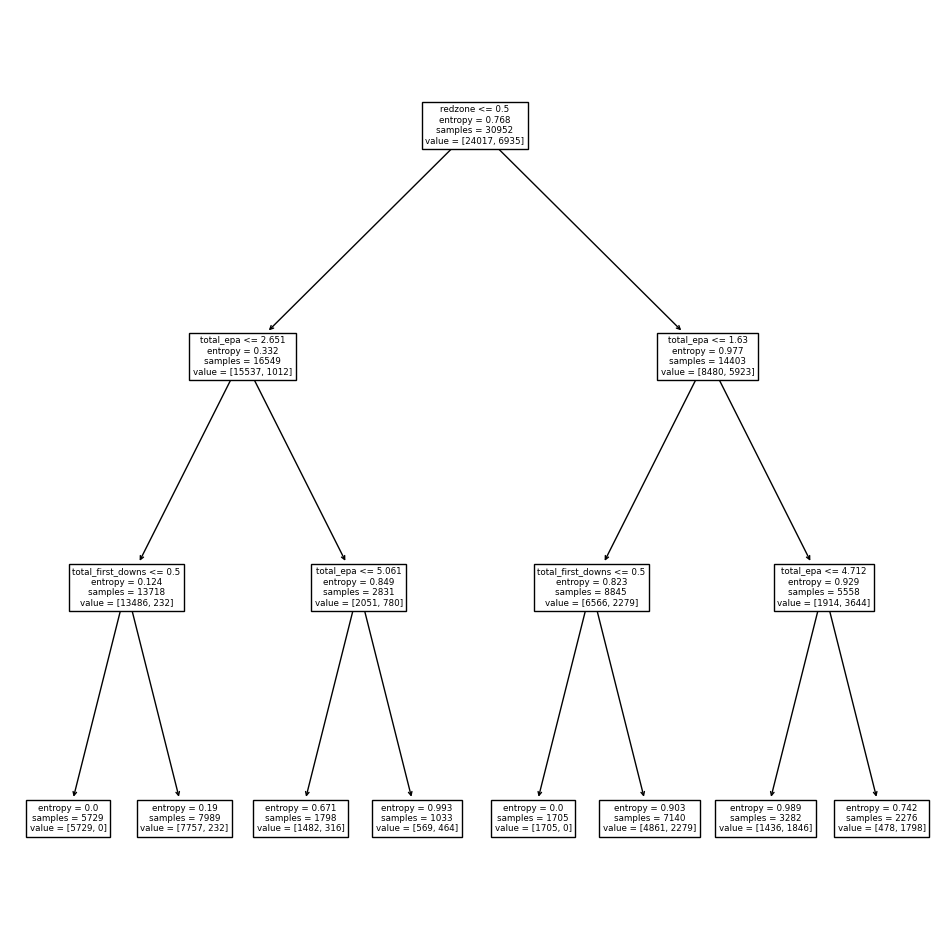

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))
plot_tree(dtc, feature_names=model_data.columns, ax=ax)
plt.show()

In [13]:
print(export_text(dtc,
feature_names=model_data.columns,
show_weights=True))

|--- redzone <= 0.50
|   |--- total_epa <= 2.65
|   |   |--- total_first_downs <= 0.50
|   |   |   |--- weights: [5729.00, 0.00] class: 0
|   |   |--- total_first_downs >  0.50
|   |   |   |--- weights: [7757.00, 232.00] class: 0
|   |--- total_epa >  2.65
|   |   |--- total_epa <= 5.06
|   |   |   |--- weights: [1482.00, 316.00] class: 0
|   |   |--- total_epa >  5.06
|   |   |   |--- weights: [569.00, 464.00] class: 0
|--- redzone >  0.50
|   |--- total_epa <= 1.63
|   |   |--- total_first_downs <= 0.50
|   |   |   |--- weights: [1705.00, 0.00] class: 0
|   |   |--- total_first_downs >  0.50
|   |   |   |--- weights: [4861.00, 2279.00] class: 0
|   |--- total_epa >  1.63
|   |   |--- total_epa <= 4.71
|   |   |   |--- weights: [1436.00, 1846.00] class: 1
|   |   |--- total_epa >  4.71
|   |   |   |--- weights: [478.00, 1798.00] class: 1



In [18]:
# Training and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

dtc = DecisionTreeClassifier(criterion="entropy", random_state=0)
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

accuracy_score(y_test, y_pred)

0.7982985138918802

In [19]:
# Pruning the tree

ccp_path = dtc.cost_complexity_pruning_path(X_train, y_train)

grid = GridSearchCV(dtc, {"ccp_alpha": ccp_path.ccp_alphas}, refit=True, cv=10, scoring="accuracy")
grid.fit(X_train, y_train)
grid.best_score_

0.8474567305008691

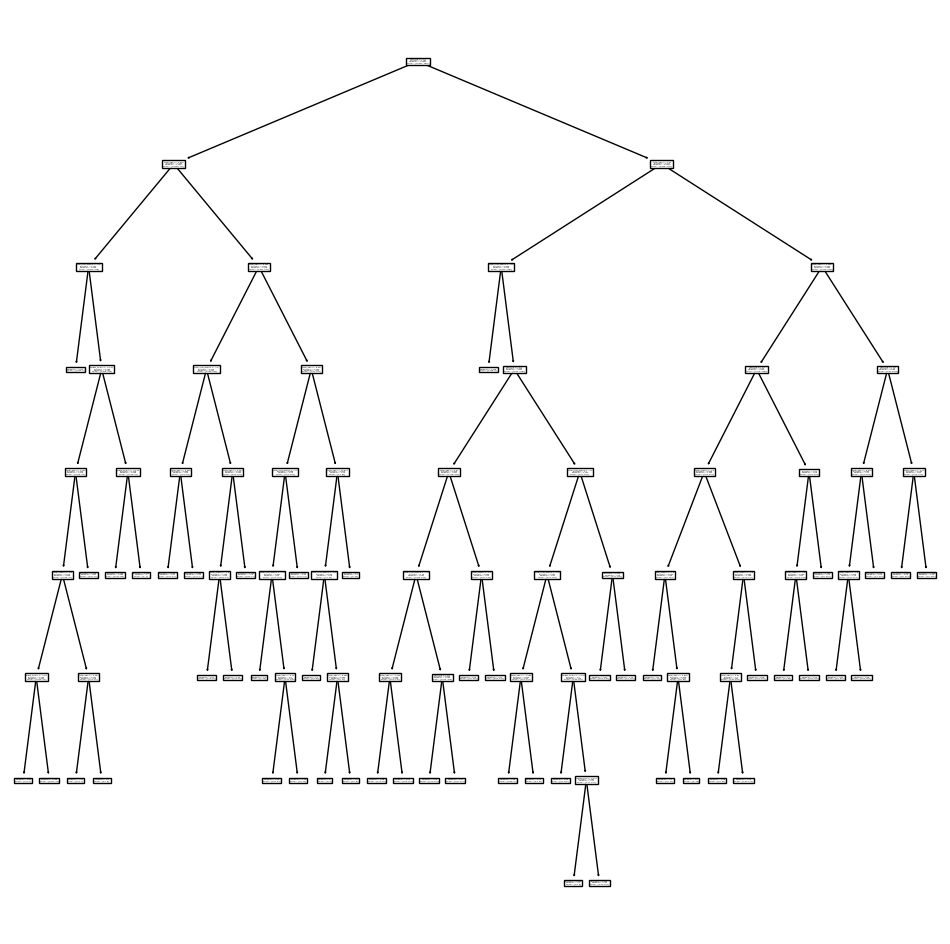

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
best_ = grid.best_estimator_
plot_tree(best_, feature_names=model_data.columns, ax=ax)
plt.show()

In [22]:
best_.tree_.n_leaves

49

In [24]:
y_pred = best_.predict(X_test)
print(accuracy_score(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
conf

0.8521430109842774


array([[6664,  530],
       [ 843, 1249]])

In [25]:
# Skipping the Regressor because I don't feel like waiting for the grid search to finish

In [43]:
# Bagging and Random Forests
#
# Reminder that bagging is a kind of Random Forest where m = p (the number of 
# predictors in each bagging set is equal to the total number of predictors)


# Model set up
X = model_data.values
y = weekly1[["fantasy_points_ppr"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Default n_estimators is 100
bagged = RandomForestRegressor(max_features=X_train.shape[1], random_state=0)
bagged.fit(X_train, y_train)

# Trying with m = sqrt(p)
rfr = RandomForestRegressor(max_features=3, random_state=0)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_features=3, random_state=0)

108.99526045898045

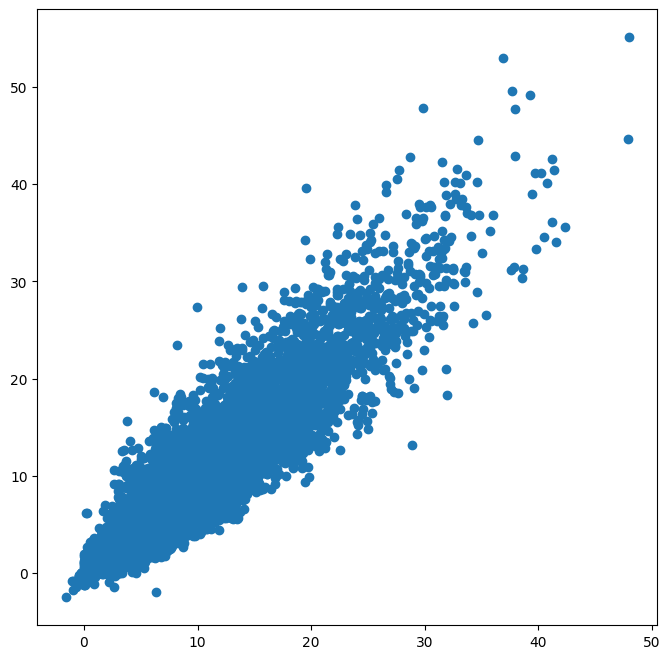

In [44]:
fig, ax = plt.subplots(figsize=(8,8))
y_pred = rfr.predict(X_test)
ax.scatter(y_pred, y_test)
np.mean((y_test - y_pred)**2)

In [45]:
feature_imp = pd.DataFrame(
{'importance ': rfr.feature_importances_},
index=model_data.columns)
feature_imp.sort_values(by='importance ', ascending=False)

,importance
total_first_downs,0.474954
total_epa,0.194971
total_usage,0.175259
target_share,0.092710
offense_pct,0.035015
redzone,0.027091


109.75856057363885

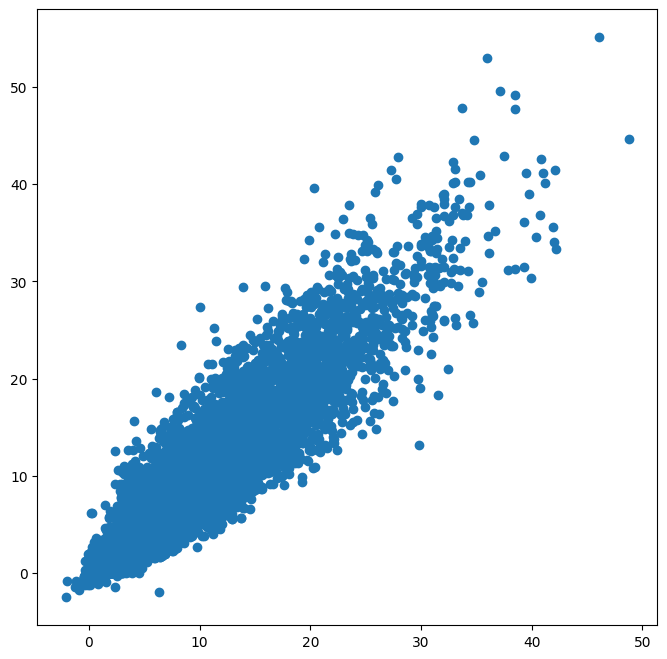

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
y_pred = bagged.predict(X_test)
ax.scatter(y_pred, y_test)
np.mean((y_test - y_pred)**2)

In [36]:
# Random Forest Classifier using m = sqrt(p) which is the default
# The regressor defaults to m = p

array([[ 5. ],
       [10.5],
       [11. ],
       ...,
       [13.4],
       [13.6],
       [ 4.5]])

In [42]:
# Model set up
X = model_data.values
y = weekly1[["scored"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Default n_estimators is 100
rfc = RandomForestClassifier(max_features=3, random_state=0)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

0.33072183076949413

In [50]:
# Model set up
X = model_data.values
y = weekly1[["fantasy_points_ppr"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

gbr = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.001, max_depth=3, random_state=0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

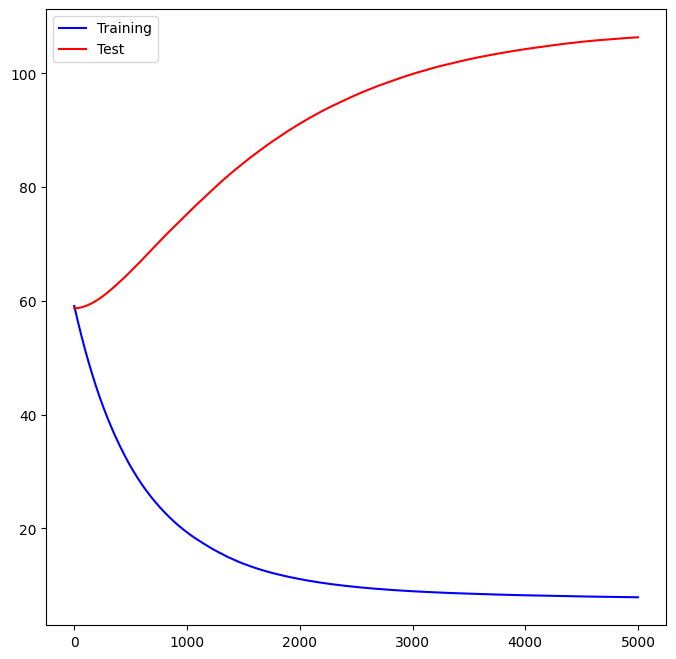

In [51]:
test_error = np.zeros_like(gbr.train_score_)
for idx, y_ in enumerate(gbr.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(gbr.train_score_.shape[0])
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(plot_idx, gbr.train_score_, "b", label="Training")
ax.plot(plot_idx, test_error, "r", label="Test")
ax.legend()
plt.show()

In [ ]:
# ISLP has a package for the BART (Bayesian Additive Regression Tree) model, so I will revisit that later